In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import os
import time
import pickle

class ReversePrediction():
    def set_seed(self, seed_value):
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        random.seed(seed_value)
        torch.manual_seed(seed_value)

    def run(self, params):
        self.set_seed(42)
        preprocessor = Preprocessor(params)
        X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

        start_time = time.time()
        model_wrapper = Model(params=params)
        model, history, y_preds, online_history = \
            model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
        end_time = time.time()
        execution_time = end_time - start_time

        y_preds = torch.tensor(y_preds, dtype=torch.float32)

        y_pred_newest = model.forward(X_newest)
        y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)

        evaluator = Evaluator(params)
        results = evaluator.get_results(y_train, y_val, y_test, y_preds, test_dataset,
                                        test_dates, history, online_history,
                                        show=False)
        results.update({'execution_time': execution_time})
        results.update({'using_data': params})
        
        results_json = json.dumps(results, indent=4)
        with open(params.get('summary_save_path'), 'w') as f:
            f.write(results_json)
            
        return results

2024-06-12 23:59:14.642072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 23:59:14.717187: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 23:59:14.734934: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 23:59:15.043498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
with open('parameters.json', 'r') as f:
    params = json.load(f)

In [3]:
params = {
    "train_indices": [
        "^GSPC",
        "^IXIC",
        "^DJI",
        "^RUA"
    ],
    "test_indices": "^GSPC",
    "start_date": "2001-01-01",
    "stop_date": "2024-01-01",
    "features_params": [
        {
            "type": "Reversals",
            "local_type": "MA",
            "oder_days": 2,
            "ma_days": 5
        },
        {
            "type": "MACD",
            "fastperiod": 5,
            "slowperiod": 10,
            "signalperiod": 9
        },
        {
            "type": "ROC",
            "trend_days": 5
        },
        {
            "type": "Stochastic Oscillator",
            "trend_days": 5
        },
        {
            "type": "CCI",
            "timeperiod": 14
        },
        {
            "type": "RSI",
            "timeperiod": 14
        },
        {
            "type": "MA",
            "timeperiod": 10
        },
        {
            "type": "VMA",
            "timeperiod": 20
        },
        {
            "type": "pctChange"
        },
        {
            "type": "13W Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "5Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "10Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "30Y Treasury Yield",
            "start_date": "2001-01-01",
            "end_date": "2024-01-01"
        },
        {
            "type": "Bollinger Bands",
            "timeperiod": 20,
            "nbdevup": 2,
            "nbdevdn": 2
        },
        {
            "type": "ATR",
            "timeperiod": 14
        },
        {
            "type": "OBV"
        },
        {
            "type": "Parabolic SAR",
            "start": 0.02,
            "increment": 0.02,
            "maximum": 0.2
        },
        {
            "type": "MOM",
            "timeperiod": 10
        },
        {
            "type": "Williams %R",
            "lookback_period": 14
        },
        {
            "type": "Chaikin MF",
            "timeperiod": 20
        }
    ],
    "data_cleaning": {
        "clean_type": "MissingData",
        "strategy": "auto"
    },
    "train_split_ratio": 0.7,
    "val_split_ratio": 0.1,
    "target_col": "Reversals",
    "feature_cols": [
        "Open",
        "High",
        "Low",
        "Close",
        "Adj Close",
        "Volume",
        "Reversals",
        "MACD_dif",
        "MACD_dem",
        "MACD_histogram",
        "ROC",
        "StoK",
        "StoD",
        "CCI",
        "RSI",
        "MA",
        "VMA",
        "pctChange",
        "13W Treasury Yield",
        "5Y Treasury Yield",
        "10Y Treasury Yield",
        "30Y Treasury Yield",
        "upperband",
        "middleband",
        "lowerband",
        "ATR",
        "OBV",
        "Parabolic SAR",
        "MOM",
        "Williams %R"
    ],
    "look_back": 64,
    "predict_steps": 15,
    "train_slide_steps": 1,
    "test_slide_steps": 15,
    "model_params": {
        "RNN": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "LSTM": {
            "hidden_size": 32,
            "num_layers": 1,
            "dropout": 0.2
        },
        "CNN_LSTM": {
            "conv_1_kernel": 3,
            "conv_1_padding": 1,
            "MaxPool1d_1_kernel_size": 2,
            "conv_2_kernel": 3,
            "conv_2_padding": 1,
            "MaxPool1d_2_kernel_size": 2,
            "num_layers": 1,
            "dropout": 0,
            "layer_sizes": [
                256,
                64,
                3
            ],
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "DNN_3layers": {
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512,
            "dropout": 0
        },
        "DNN_5layers": {
            "dropout": 0.2
        },
        "DummyClassifier": {},
        "DNN_FlexibleLayers": {
            "num_layers": 3,
            "layer_sizes": [
                2048,
                512,
                3
            ],
            "dropout": 0,
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "LeNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ],
                "MaxPool1d_kernel_size": [
                    2,
                    2,
                    2
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ]
            },
            "dropout": 0,
            "fc_1_out_features": 2048,
            "fc_2_out_features": 512
        },
        "AlexNet": {
            "cnn_layers": {
                "kernel_sizes": [
                    5,
                    5,
                    5
                ],
                "paddings": [
                    2,
                    2,
                    2
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    2048,
                    512,
                    3
                ],
                "dropout": 0
            }
        },
        "VGG": {
            "cnn_layers": {
                "kernel_sizes": [
                    3,
                    3,
                    3,
                    3
                ],
                "paddings": [
                    1,
                    1,
                    1,
                    1
                ]
            },
            "fc_layers": {
                "layer_sizes": [
                    5248,
                    512,
                    3
                ]
            },
            "dropout": 0
        }
    },
    "model_type": "DNN_FlexibleLayers",
    "training_epoch_num": 10000,
    "online_training_epoch_num": 200,
    "online_train_update_interval": 30,
    "learning_rate": 1e-06,
    "online_train_learning_rate": 1e-06,
    "weight_decay": 0,
    "online_train_weight_decay": 0,
    "batch_size": 4096,
    "patience": 50,
    "min_delta": 0,
    "shuffle": False,
    "data_update_mode": "append",
    "trained_model_path": "models/",
    "online_trained_model_path": "models/",
    "reversals_ratio_path": "plots/reversals_ratio.png",
    "confusion_matrix_path": "plots/confusion_matrix.png",
    "training_curve_path": "plots/training_curve.png",
    "online_training_curve_path": "plots/online_training_curve.png",
    "pr_auc_path": "plots/pr_auc.png",
    "roc_auc_path": "plots/roc_auc.png",
    "stock_and_predictions_path": "plots/stock_and_predictions.png",
    "summary_save_path": "reports/summary.json",
    "val_training_curve_path": "plots/val_training_curve.png"
}

In [4]:
import yfinance as yf


In [5]:
params["model_type"] = 'CNN_LSTM'

In [6]:
rp = ReversePrediction() 
rp.set_seed(42)
# results = rp.run(params)

In [7]:
preprocessor = Preprocessor(params)
X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset = preprocessor.get_multiple_data()

[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_max_indices] = 1
/home/tony/reverse_predict/reversePrediction/preprocessor/preprocessor_pytorch.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Reversals'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape: torch.Size([15811, 64, 30])
Validation set shape: torch.Size([498, 64, 30])
Test set shape: torch.Size([72, 64, 30])


In [20]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset
import glob
from collections import Counter

# TODO: 調整變數名稱，將常數以大寫表示，把input_shape拿掉
class EarlyStopper:
    def __init__(self, patience=int(3), min_delta=float(0.01)):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, feature, type='loss'):
        """
        Checks if early stopping criteria is met.

        Args:
            validation_loss (float): The validation loss.

        Returns:
            bool: True if early stopping criteria is met, False otherwise.
        """
        if type == 'loss':
            if feature < self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        elif type == 'accuracy':
            if feature > self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature < (self.min_validation_loss - self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
    
class ModelBase(object):
    def _train_model(self):
        """
        Trains the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _infer_model(self):
        """
        Infers the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _online_training_model(self):
        """
        Performs online training of the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

class NeuralNetworkModelBase(ModelBase):
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params
    
    def _train_model(self, model, X_train, y_train, X_val, y_val):
        """
        Trains the model.
        """
        # Initialize variables for storing validation loss history
        val_loss_history = []
        epoch_counter = 0
        rollback_epoch = None

        train_loss_function = nn.CrossEntropyLoss()
        val_loss_function = nn.CrossEntropyLoss()

        # TODO: add function to change optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        early_stopper = EarlyStopper(patience=self.params['patience'], min_delta=self.params['min_delta']) 

        train_losses = []
        train_accuracy = []
        train_batch_losses = []
        train_batch_accuracy = []
        val_losses = []
        val_accuracy = []
        rollback_epoch = None

        num_epochs = self.params['training_epoch_num']
        batch_size = self.params['batch_size']
        num_samples = X_train.size(0)

        for epoch in tqdm(range(num_epochs), file=open("log.txt", "a")):
            model.train()

            # Iterate over batches
            for i in range(0, num_samples, batch_size):
                # Get batch
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # forward pass
                outputs = model(X_batch)
                loss = train_loss_function(outputs, y_batch)
                # backward pass and update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # calculate training accuracy
                _, predicted = torch.max(outputs.data, -1)
                correct = (predicted == y_batch.argmax(dim=-1)).sum().item()
                accuracy = correct / (y_batch.size(0))
                train_batch_losses.append(loss.item())
                train_batch_accuracy.append(accuracy)
            train_losses.append(loss.item())
            train_accuracy.append(accuracy)
            # calculate validation loss
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = val_loss_function(val_outputs, y_val)
                _, val_predicted = torch.max(val_outputs.data, -1)
                val_correct = (val_predicted == y_val.argmax(dim=-1)).sum().item()
                accuracy = val_correct / (y_val.size(0))
                val_losses.append(val_loss.item())
                val_accuracy.append(accuracy)

            # Early stopping based on validation loss
            if early_stopper.early_stop(val_loss.item(), type='loss'): 
                # Store validation loss and corresponding epoch
                val_loss_history.append((epoch_counter, val_loss.item()))
                rollback_epoch = epoch_counter - self.params['patience']
                print('rollback_epoch:', rollback_epoch)
                break

            # Store validation loss and corresponding epoch
            val_loss_history.append((epoch_counter, val_loss.item()))
            epoch_counter += 1

            # Save model checkpoint
            torch.save(model.state_dict(), f"{self.params.get('trained_model_path')}/model_checkpoint_{epoch_counter}.pt")
            
        if rollback_epoch is not None:
            model.load_state_dict(torch.load(f"{self.params.get('trained_model_path')}/model_checkpoint_{rollback_epoch}.pt"))
        # Delete all .pt files

        for file_path in glob.glob(f"{self.params.get('trained_model_path')}/*.pt"):
            os.remove(file_path)

        history = {
            'loss': train_losses,
            'accuracy': train_accuracy,
            'batch_loss': train_batch_losses,
            'batch_accuracy': train_batch_accuracy,
            'val_loss': val_losses,
            'val_accuracy': val_accuracy,
            'rollback_epoch': rollback_epoch
        }
        return history, model

    def _infer_model(self, model, X_test):
        """
        Infers the model.

        Args:
            model: The PyTorch model.
            X_test: The input test data.

        Returns:
            The predicted values.
        """
        y_pred = model(X_test)
        return y_pred

    def _update_training_dataset(self, X_train, y_train, single_X_test, single_y_test, data_update_mode):
        if data_update_mode == 'append':
            updated_X_train = torch.cat((X_train, single_X_test), dim=0)
            updated_y_train = torch.cat((y_train, single_y_test), dim=0)
        elif data_update_mode == 'replace':
            updated_X_train = torch.cat((X_train[1:], single_X_test), dim=0)
            updated_y_train = torch.cat((y_train[1:], single_y_test), dim=0)
        elif data_update_mode == 'newest':
            updated_X_train = single_X_test
            updated_y_train = single_y_test
        else:
            raise ValueError(f"Invalid data update mode: {data_update_mode}")
        return updated_X_train, updated_y_train

    def _online_train_model(self, model, X_train, y_train):
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['online_train_learning_rate'], weight_decay=self.params['online_train_weight_decay'])
        num_epochs = self.params['online_training_epoch_num']
        online_train_history = {}
        online_train_loss = []
        online_train_accuracy = []
        
        for epoch in tqdm(range(num_epochs)):
            # Retrain the model on this updated dataset
            model.train()
            optimizer.zero_grad()

            # forward pass
            outputs = model(X_train)
            loss = loss_function(outputs, y_train)
            _, predicted = torch.max(outputs.data, -1)
            correct = (predicted == y_train.argmax(dim=-1)).sum().item()
            accuracy = correct / y_train.size(0)
            
            # backward pass and update weights
            loss.backward()
            optimizer.step()
            
            online_train_loss.append(loss.item())
            online_train_accuracy.append(accuracy)
        
        online_train_history = {
            'loss': loss.item() / y_train.size(-2),
            'accuracy': accuracy,
            'epoch_loss': online_train_loss,
            'epoch_accuracy': online_train_accuracy
        }
        
        return online_train_history, model


class DummyClassifierModelBase(ModelBase):
    def __init__(self, params, input_shape):
        super(DummyClassifierModelBase, self).__init__()
        self.params = params
        
    def _train_model(self, model, X_train, y_train, X_val, y_val):
        label_counts = Counter(y_train)
        self.most_common_label = label_counts.most_common(1)[0][0]

        history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }
        return history, model

    def _infer_model(self, model, X_test):
        batch_size = X_test.size(0)
        predictions = torch.randint(0, 2, (batch_size, self.params['predict_steps'], 2), dtype=torch.float32)
        return predictions

    def _online_train_model(self, model, X_train, y_train, single_X_test, 
                        single_y_test, data_update_mode='append'):
        history = {
            'loss': [],
            'accuracy': []
            }
        return history, model

class ModelLeNet_2layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLeNet_2layers, self).__init__()
        self.params = params

        # Convolution layers
        self.conv1 = nn.Conv1d(input_shape[1],
                               self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_1_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_1_padding"])
        self.conv2 = nn.Conv1d(self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               self.params["model_params"]["LeNet_2"]["conv_2_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_2_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_2_padding"])

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.ModuleList([
            self.conv1,
            nn.LayerNorm([self.feature_num, self.params["look_back"]]),
            nn.ReLU(),
            # nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.feature_num, int(self.params["look_back"])]),
            nn.ReLU(),
            # nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_2_kernel_size"])
        ])
        self._get_conv_output((1, input_shape[1], self.params["look_back"]))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.ln1 = nn.LayerNorm(self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.fc2 = nn.Linear(self.params["model_params"]["LeNet_2"]["fc_1_out_features"],
                             self.params["predict_steps"] * 2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(-1, 2, self.params["predict_steps"])  # Reshape to the desired output shape
        return x

class ModelRNN(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelRNN, self).__init__()
        self.params = params
        self.rnn = nn.RNN(input_size=input_shape[-1],
                          hidden_size=self.params["model_params"]["RNN"]["hidden_size"],
                          num_layers=self.params["model_params"]["RNN"]["num_layers"],
                          dropout=self.params["model_params"]["RNN"]["dropout"],
                          batch_first=True)
        self.lc = nn.LayerNorm([self.params["look_back"], self.params["model_params"]["RNN"]["hidden_size"]])
        self.fc = nn.Linear(self.params["model_params"]["RNN"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through RNN
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, hidden = self.rnn(x, hidden)
        output = self.lc(output)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["RNN"]["hidden_size"])
        output = self.fc(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = torch.sigmoid(output)
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state
        return torch.zeros(self.params["model_params"]["RNN"]["num_layers"], batch_size, self.params["model_params"]["RNN"]["hidden_size"])

class ModelLSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLSTM, self).__init__()
        self.params = params
        self.lstm = nn.LSTM(input_size=input_shape[-1],
                            hidden_size=self.params["model_params"]["LSTM"]["hidden_size"],
                            num_layers=self.params["model_params"]["LSTM"]["num_layers"],
                            dropout=self.params["model_params"]["LSTM"]["dropout"],
                            batch_first=True)
        self.fc = nn.Linear(self.params["model_params"]["LSTM"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through LSTM
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["LSTM"]["hidden_size"])
        output = self.fc(output)
        output = torch.sigmoid(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state and cell state
        hidden_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        cell_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        return (hidden_state, cell_state)

class ModelDNN_5layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_5layers, self).__init__()
        self.params = params
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, self.predict_steps*32)
        self.fc2 = nn.Linear(self.predict_steps*32, self.predict_steps*16)
        self.fc3 = nn.Linear(self.predict_steps*16, self.predict_steps*8)
        self.fc4 = nn.Linear(self.predict_steps*8, self.predict_steps*4)
        self.fc5 = nn.Linear(self.predict_steps*4, 3)

        # Layer normalization and dropout
        self.ln1 = nn.LayerNorm(self.predict_steps*32)
        self.ln2 = nn.LayerNorm(self.predict_steps*16)
        self.ln3 = nn.LayerNorm(self.predict_steps*8)
        self.ln4 = nn.LayerNorm(self.predict_steps*4)
        # Remove LayerNorm from the last layer
        self.dropout = nn.Dropout(self.params['model_params']["DNN_5layers"]['dropout'])

        # Apply He Initialization to each linear layer
        self._init_weights()

    def _init_weights(self):
        # Use He initialization for each linear layer
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc5.weight)
        
        # Optional: Initialize biases with zeros or another method
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
        nn.init.zeros_(self.fc5.bias)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.dropout(x)
        # Final layer without LayerNorm but with ReLU
        x = self.fc5(x)
        # No sigmoid activation here, let CrossEntropyLoss handle it
        output = x  # Output shape: [batch_size, num_classes]

        return output
    
class ModelDNN_3layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_3layers, self).__init__()
        self.params = params
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        self.fc_1_out_features = self.params['model_params']["DNN_3layers"].get('fc_1_out_features', 64)
        self.fc_2_out_features = self.params['model_params']["DNN_3layers"].get('fc_2_out_features', 16)
        # Define the layers
        # self.fc1 = nn.Linear(input_size, self.predict_steps*64)
        # self.fc2 = nn.Linear(self.predict_steps*64, self.predict_steps*16)
        # self.fc3 = nn.Linear(self.predict_steps*16, 3)
        self.fc1 = nn.Linear(input_size, self.fc_1_out_features)
        self.fc2 = nn.Linear(self.fc_1_out_features, self.fc_2_out_features)
        self.fc3 = nn.Linear(self.fc_2_out_features, 3)
        
        # Layer normalization and dropout
        # self.ln1 = nn.LayerNorm(self.predict_steps*64)
        # self.ln2 = nn.LayerNorm(self.predict_steps*16)
        self.ln1 = nn.LayerNorm(self.fc_1_out_features)
        self.ln2 = nn.LayerNorm(self.fc_2_out_features)
        
        # Remove LayerNorm from the last layer
        self.dropout = nn.Dropout(self.params['model_params']["DNN_3layers"]['dropout'])

        # Apply He Initialization to each linear layer
        self._init_weights()

    def _init_weights(self):
        # Use He initialization for each linear layer
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc3.weight)
        # Optional: Initialize biases with zeros or another method
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        # Final layer without LayerNorm but with ReLU
        x = self.fc3(x)
        # No sigmoid activation here, let CrossEntropyLoss handle it
        output = x  # Output shape: [batch_size, num_classes]

        return output


class ModelDNN_FlexibleLayers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_FlexibleLayers, self).__init__()
        self.params = params
        
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        self.feature_num = len(params["feature_cols"])
        
        # Layer parameters from params
        
        layer_params = self.params['model_params']["DNN_FlexibleLayers"]
        self.fc_layer_sizes = layer_params.get('layer_sizes', [64, 16])
        self.num_fc_layers = len(self.fc_layer_sizes)
        self.dropout_rate = layer_params.get('dropout', 0.5)
        
        # Ensure layer_sizes has enough sizes for the num_layers
        if len(self.fc_layer_sizes) < self.num_fc_layers - 1:
            raise ValueError("Not enough layer sizes specified for the number of layers")
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num*self.params["look_back"]
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Apply He Initialization
        self._init_weights()

    def _init_weights(self):
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        
        return x
    
class DummyClassifier(nn.Module, DummyClassifierModelBase):
    def __init__(self, params, input_shape):
        super(DummyClassifier, self).__init__()
        self.params = params
        self.predict_steps = self.params['predict_steps']

    def forward(self, x):
        # 獲取批次大小
        batch_size = x.size(0)
        # 隨機生成輸出，這裡假設輸出類別數為2，調整為需要的任何數量
        # 使用 torch.rand 生成介於 [0, 1) 的隨機數據，模擬隨機預測的結果
        random_output = torch.rand(batch_size, self.predict_steps, 2)
        return random_output

import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelCNN_LSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelCNN_LSTM, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Convolution layers
        self.conv1 = nn.Conv1d(
            in_channels=self.feature_num,
            out_channels=self.feature_num,
            kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_1_kernel"],
            padding=self.params["model_params"]["CNN_LSTM"]["conv_1_padding"],
            groups=self.feature_num
        )
        self.conv2 = nn.Conv1d(
            in_channels=self.feature_num,
            out_channels=self.feature_num,
            kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_2_kernel"],
            padding=self.params["model_params"]["CNN_LSTM"]["conv_2_padding"],
            groups=self.feature_num
        )
        
        # Sequential container for convolution and pooling layers
        self.convs = nn.Sequential(
            self.conv1,
            nn.LayerNorm([self.feature_num, int(self.params["look_back"])]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.feature_num, int(self.params["look_back"]) // int(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_1_kernel_size"])]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool1d_2_kernel_size"])
        )

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.feature_num,
            hidden_size=self.feature_num,
            num_layers=self.params["model_params"]["CNN_LSTM"]["num_layers"],
            dropout=self.params["model_params"]["CNN_LSTM"]["dropout"],
            batch_first=True
        )
        
        # Fully connected layers
        layer_params = self.params['model_params']["CNN_LSTM"]
        self.fc_layer_sizes = layer_params.get('layer_sizes', [64, 16])
        self.num_fc_layers = len(self.fc_layer_sizes)
        self.dropout_rate = layer_params.get('dropout', 0.5)
        
        if len(self.fc_layer_sizes) < self.num_fc_layers - 1:
            raise ValueError("Not enough layer sizes specified for the number of layers")
        
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num
        
        for out_size in self.fc_layer_sizes:
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        self.fc_layers.append(nn.Linear(fc_input_size, 3))
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.params["model_params"]["CNN_LSTM"]["num_layers"], batch_size, self.feature_num)
        cell_state = torch.zeros(self.params["model_params"]["CNN_LSTM"]["num_layers"], batch_size, self.feature_num)
        return (hidden_state, cell_state)
        
    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        x = self.convs(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        x, _ = self.lstm(x, hidden)
        x = x[:, -1, :]
        
        x = x.contiguous().view(batch_size, -1)
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.Linear):
                x = layer(x)
            elif isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
        return x

class ModelLeNet(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelLeNet, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Extract parameters for CNN layers
        cnn_params = self.params['model_params']['LeNet']['cnn_layers']
        self.num_cnn_layers = len(cnn_params['kernel_sizes'])
        self.cnn_kernel_sizes = cnn_params['kernel_sizes']
        self.cnn_paddings = cnn_params['paddings']
        self.MaxPool1d_kernel_size = cnn_params['MaxPool1d_kernel_size']
        
        # Extract parameters for FC layers
        fc_params = self.params['model_params']['LeNet']['fc_layers']
        self.num_fc_layers = len(fc_params['layer_sizes'])
        self.fc_layer_sizes = fc_params['layer_sizes']
        self.dropout_rate = self.params['model_params']['LeNet'].get('dropout', 0.5)
        
        # Define CNN layers
        self.cnn_layers = nn.ModuleList()
        for i in range(self.num_cnn_layers):
            kernel_size = self.cnn_kernel_sizes[i]
            padding = self.cnn_paddings[i]
            self.cnn_layers.append(nn.Conv1d(in_channels=self.feature_num,
                                             out_channels=self.feature_num,
                                             kernel_size=kernel_size,
                                             padding=padding,
                                             groups=self.feature_num))
            input_shape = ([self.feature_num, self.params["look_back"]])
            self.cnn_layers.append(nn.LayerNorm(input_shape))
            self.cnn_layers.append(nn.MaxPool1d(self.MaxPool1d_kernel_size[i]))
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num * self.params["look_back"]
        for pool_kernel_size in self.MaxPool1d_kernel_size:
            fc_input_size //= pool_kernel_size
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for convolutional layers
        for layer in self.cnn_layers:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        
        # Initialize weights for fully connected layers
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
                
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)

    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Apply CNN layers
        for i, layer in enumerate(self.cnn_layers):
            if isinstance(layer, nn.Conv1d):
                x = F.relu(layer(x))
            if isinstance(layer, nn.LayerNorm):
                x = self.dropout(x)
            if isinstance(layer, nn.MaxPool1d):
                x = layer(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Flatten the input for FC layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Apply FC layers
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        
        return x

class ModelAlexNet(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelAlexNet, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Extract parameters for CNN layers
        cnn_params = self.params['model_params']['AlexNet']['cnn_layers']
        self.num_cnn_layers = len(cnn_params['kernel_sizes'])
        self.cnn_kernel_sizes = cnn_params['kernel_sizes']
        self.cnn_paddings = cnn_params['paddings']
        
        # Extract parameters for FC layers
        fc_params = self.params['model_params']['AlexNet']['fc_layers']
        self.num_fc_layers = len(fc_params['layer_sizes'])
        self.fc_layer_sizes = fc_params['layer_sizes']
        self.dropout_rate = self.params['model_params']['AlexNet'].get('dropout', 0.5)
        
        # Define CNN layers
        self.cnn_layers = nn.ModuleList()
        for i in range(self.num_cnn_layers):
            kernel_size = self.cnn_kernel_sizes[i]
            padding = self.cnn_paddings[i]
            self.cnn_layers.append(nn.Conv1d(in_channels=self.feature_num,
                                             out_channels=self.feature_num,
                                             kernel_size=kernel_size,
                                             padding=padding, groups=self.feature_num))
            self.cnn_layers.append(nn.ReLU(inplace=True))
            # self.cnn_layers.append(nn.MaxPool1d(kernel_size=3, stride=2))
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num*self.params["look_back"]
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for convolutional layers
        for layer in self.cnn_layers:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)
        
        # Initialize weights for fully connected layers
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, 0, 0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)
        
    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Apply CNN layers
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Flatten the input for FC layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        
        # Apply FC layers
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        return x

class ModelVGG(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelVGG, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        self.predict_steps = self.params['predict_steps']
        
        # Extract parameters for CNN layers
        cnn_params = self.params['model_params']['VGG']['cnn_layers']
        self.num_cnn_layers = len(cnn_params['kernel_sizes'])
        self.cnn_kernel_sizes = cnn_params['kernel_sizes']
        self.cnn_paddings = cnn_params['paddings']
        
        # Extract parameters for FC layers
        fc_params = self.params['model_params']['VGG']['fc_layers']
        self.num_fc_layers = len(fc_params['layer_sizes'])
        self.fc_layer_sizes = fc_params['layer_sizes']
        self.dropout_rate = self.params['model_params']['VGG'].get('dropout', 0.5)
        
        # Define CNN layers
        self.cnn_layers = nn.ModuleList()
        for i in range(self.num_cnn_layers):
            kernel_size = self.cnn_kernel_sizes[i]
            padding = self.cnn_paddings[i]
            self.cnn_layers.append(nn.Conv1d(in_channels=self.feature_num,
                                             out_channels=self.feature_num,
                                             kernel_size=kernel_size,
                                             padding=padding, groups=self.feature_num))
            self.cnn_layers.append(nn.ReLU(inplace=True))
            # self.cnn_layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        
        # Define FC layers
        self.fc_layers = nn.ModuleList()
        fc_input_size = self.feature_num*self.params["look_back"]
        for i in range(self.num_fc_layers):
            out_size = self.fc_layer_sizes[i]
            self.fc_layers.append(nn.Linear(fc_input_size, out_size))
            if i < self.num_fc_layers - 1:
                self.fc_layers.append(nn.LayerNorm(out_size))
            fc_input_size = out_size
        
        # Dropout
        self.dropout = nn.Dropout(self.dropout_rate)
        
        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for convolutional layers
        for layer in self.cnn_layers:
            if isinstance(layer, nn.Conv1d):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        
        # Initialize weights for fully connected layers
        for layer in self.fc_layers[:-1]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.fc_layers[-1].weight)
        nn.init.zeros_(self.fc_layers[-1].bias)

    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        # Apply CNN layers
        for layer in self.cnn_layers:
            x = layer(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        
        # Flatten the input for FC layers
        x = x.view(x.size(0), -1)
        
        # Apply FC layers
        for i, layer in enumerate(self.fc_layers):
            if isinstance(layer, nn.LayerNorm):
                x = F.relu(layer(x))
                x = self.dropout(x)
            else:
                x = layer(x)
        
        return x


class ModelFactory:
    @staticmethod
    def create_model_instance(model_type, params=None, input_shape=None):
        """
        Creates an instance of the specified model type.

        Args:
            model_type (str): The type of the model to create.
            params (dict): A dictionary containing the parameters for the model.
            input_shape (tuple): The shape of the input data.
            keras_model: The Keras model to be converted to PyTorch model.

        Returns:
            An instance of the specified model type.
        """
        models = {
            "LeNet": ModelLeNet,
            "LeNet_2": ModelLeNet_2layers,
            "RNN": ModelRNN,
            "LSTM": ModelLSTM,
            # "DNN_1layer": ModelDNN_1layer,
            # "DNN_3layers": ModelDNN_3layers,
            "DNN_5layers": ModelDNN_5layers,
            "DNN_3layers": ModelDNN_3layers,
            # "DNN_7layers": ModelDNN_7layers,
            "CNN_LSTM": ModelCNN_LSTM,
            # "seq2seq": Modelseq2seq,
            # "cnn": ModelCNN,
            # "fft": ModelFFT,
            # "ma": ModelMA,
            "DummyClassifier": DummyClassifier,
            "DNN_FlexibleLayers": ModelDNN_FlexibleLayers,
            "LeNet": ModelLeNet,
            "AlexNet": ModelAlexNet,
            "VGG": ModelVGG,
            # Add other models here as needed
        }
        model_instance = models.get(model_type)
        if model_instance is None:
            raise ValueError(f"Invalid model type: {model_type}")
        instance = model_instance(params, input_shape)
        return instance

class Model:
    """A class representing a model for training and inference."""
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params
        
    def create_model(self, model_type, input_shape=None):
        """Create a model instance.

        Args:
            model_type (str): The type of the model.
            params (dict, optional): The parameters for the model. Defaults to None.
            input_shape (tuple, optional): The shape of the input data. Defaults to None.

        Returns:
            model_instance: The created model instance.
        """
        model_instance = ModelFactory.create_model_instance(
            model_type, self.params, input_shape)
        return model_instance

    def train_model(self, model, X_train, y_train, X_val, y_val):
        """Train the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.

        Returns:
            The trained model.
        """
        return model._train_model(model, X_train, y_train, X_val, y_val)

    def infer_model(self, model, X_test):
        """Perform inference using the model.

        Args:
            model: The model instance.
            X_test: The input data for inference.

        Returns:
            The predicted output.
        """
        return model._infer_model(model, X_test)
    
    def update_training_dataset(self, model, X_train, y_train, single_X_test, single_y_test, data_update_mode):
        return model._update_training_dataset(X_train, y_train, single_X_test, single_y_test, data_update_mode)

    def online_train_model(self, model, X_train, y_train):
        """Perform online training on the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.
            single_X_test: The input data for online training.
            single_y_test: The target data for online training.

        Returns:
            The updated model.
        """
        return model._online_train_model(model, X_train, y_train)

    def run(self, X_train, y_train, X_test, y_test, X_val, y_val, pre_trained_model_path=None):
        """Run the model.

        Args:
            model_type (str): The type of the model.
            look_back (int): The number of previous time steps to consider.
            params (dict): The parameters for the model.
            X_train: The training input data.
            y_train: The training target data.
            X_test: The test input data.
            y_test: The test target data.
            pre_trained_model_path (str, optional): The path to a pre-trained model. Defaults to None.

        Returns:
            tuple: A tuple containing the trained model, training history, predicted outputs, 
            online training losses, and online training accuracy.
        """
        if pre_trained_model_path is not None:
            # model = torch.load(pre_trained_model_path)
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            model.load_state_dict(torch.load(pre_trained_model_path))
            history = None
        else:
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            history, model = self.train_model(model, X_train, y_train, X_val, y_val)
            # torch.save(model, self.params['trained_model_path'])
            # torch.save(model.state_dict(), os.path.join(save_path_root, self.params['trained_model_path']))
        online_history = {
            'loss': [],
            'accuracy': [],
            'epoch_loss': [],
            'epoch_accuracy': []
        }
        y_preds = []
        updated_x_train = X_train
        updated_y_train = y_train
        update_interval = self.params['online_train_update_interval']
        counter = 0
        
        for i in tqdm(range(len(X_test)), file=open("log.txt", "a")):
            y_pred = self.infer_model(model, X_test[i:i+1])
            y_preds.append(y_pred[0])
            counter += 1
            
            if counter == update_interval:
                updated_x_train, updated_y_train = self.update_training_dataset(
                    model, updated_x_train, updated_y_train, X_test[i-update_interval+1:i+1], y_test[i-update_interval+1:i+1], self.params['data_update_mode'])
                sub_online_history, model = self.online_train_model(
                    model, updated_x_train, updated_y_train)
                online_history['loss'].append(sub_online_history['loss'])
                online_history['accuracy'].append(
                    sub_online_history['accuracy'])
                online_history['epoch_loss'].append(
                    sub_online_history['epoch_loss'])
                online_history['epoch_accuracy'].append(
                    sub_online_history['epoch_accuracy'])
                counter = 0
        
        # torch.save(model, os.path.join(save_path_root, self.params['online_trained_model_path']))
        y_preds = torch.stack(y_preds).detach().numpy()

        return model, history, y_preds, online_history


In [21]:
start_time = time.time()
model_wrapper = Model(params=params)
model, history, y_preds, online_history = \
    model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
end_time = time.time()
execution_time = end_time - start_time


In [ ]:
y_preds = torch.tensor(y_preds, dtype=torch.float32)
y_preds_original = y_preds.clone()


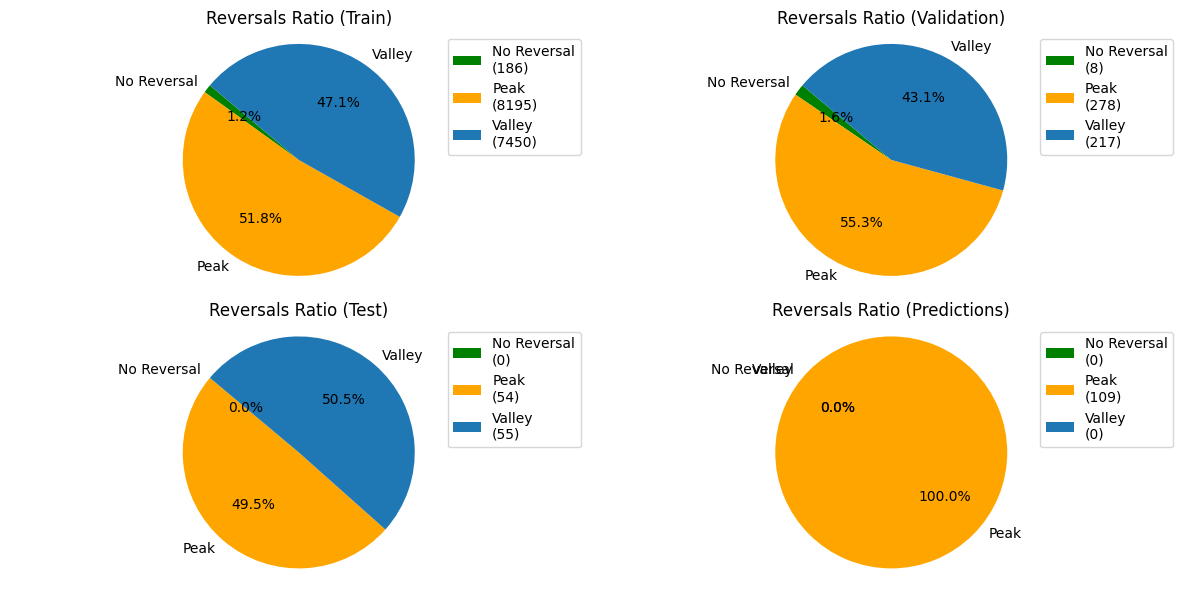

['Peak'] [0.49541284 0.        ] [1. 0.] [0.66257669 0.        ] [0. 1.] [1. 0.] [0. 1.] 0.4954128440366973


ValueError: All arrays must be of the same length

In [ ]:
evaluator = Evaluator(params)
results = evaluator.get_results(y_train, y_val, y_test, y_preds, test_dataset, test_dates, history, online_history, show=True)